# RNNs Tutorial with PyTorch on the IMDB Dataset

In this tutorial, we will build a Recurrent Neural Network (CNN) to classify movie reviews as positive or negative using the IMDB dataset.
 
We'll go through the following steps:

1. **Data Loading, Processing, and Augmentation**
2. **Data Exploration**
3. **Model Building**
4. **Model Training**
5. **Model Evaluation**



## 1. Data Loading, Processing, and Augmentation

The IMDB dataset contains 50,000 movie reviews, split into 25,000 reviews for training and 25,000 reviews for testing. The dataset is preprocessed, and each review is encoded as a sequence of word indexes.

### Exercise 1.1 - Data Loading and Processing

1. Load the data from `'../../data/imdb_dataset.zip'` using pandas.
2. Convert the `sentiment` column to a binary label (0 for negative and 1 for positive).
3. Split the dataset into training and test sets (25,000 samples each).
4. Preprocess the `review` column by converting it to lowercase and removing special characters, punctuation and stopwords. Additionally, use a stemming or lemmatization technique.
5. Build a vocabulary of unique words in the training dataset.
6. Tokenize the reviews using the vocabulary, i.e., replace each word with its index in the vocabulary. Note that the reviews should be padded to a fixed length.
7. Create the data loaders for training and test datasets.


In [44]:
import modin.pandas as pd

df = pd.read_csv('../../data/imdb_dataset.zip', compression='zip')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [45]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [46]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.5, random_state=42, stratify=df['sentiment'])

train.shape, test.shape

((25000, 2), (25000, 2))

In [47]:
train['sentiment'].value_counts(), test['sentiment'].value_counts()

(sentiment
 0    12500
 1    12500
 Name: count, dtype: int64,
 sentiment
 0    12500
 1    12500
 Name: count, dtype: int64)

In [48]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
train.head

<bound method BasePandasDataset.head of                                                   review  sentiment
3055   Trio's vignettes were insightful and quite enj...          1
47326  I had never heard of this one before the owner...          0
48869  This is an excellent but hard to find trippy W...          1
48623  I am a huge fan of big, loud, trashy, complete...          1
39657  Easily Lucio Fulci's most respected film, "Don...          1
...                                                  ...        ...
21552  Recent years have seen a number of biopics of ...          1
10610  You may say to yourself, "Don Johnson as Elvis...          0
20104  The title refers not to a questionable poker h...          1
35597  this is by far the most pathetic movie Indian ...          0
27491  This movie forever left an impression on me. I...          0

[25000 rows x 2 columns]>

In [50]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\W+', ' ', text)  # Remove non-word/non-whitespace characters
    text = re.sub(r'\d+', '', text)  # Remove digits
    tokens = [word for word in text.split()]  # Tokenize text
    words = [word for word in tokens if word not in stop_words]  # Remove stop words
    words = [stemmer.stem(word) for word in words]  # Perform stemming
    return ' '.join(words)

In [51]:
train['prepoc_review'] = train['review'].apply(preprocess_text)
test['prepoc_review'] = test['review'].apply(preprocess_text)

train.head()

,review,sentiment,prepoc_review
3055,Trio's vignettes were insightful and quite enj...,1,trio vignett insight quit enjoy curiou see man...
47326,I had never heard of this one before the owner...,0,never heard one owner local dvd rental outlet ...
48869,This is an excellent but hard to find trippy W...,1,excel hard find trippi world war spi thriller ...
48623,"I am a huge fan of big, loud, trashy, complete...",1,huge fan big loud trashi complet stupid action...
39657,"Easily Lucio Fulci's most respected film, ""Don...",1,easili lucio fulci respect film tortur duckl h...


In [52]:
def tokenize_text(text):
    return word_tokenize(text)

train['tokens'] = train['prepoc_review'].apply(tokenize_text)
test['tokens'] = test['prepoc_review'].apply(tokenize_text)

In [53]:
top5000 = pd.Series([word for tokens in train['tokens'] for word in tokens]).value_counts().index[:5000]

top5000

Index(['br', 'movi', 'film', 'one', 'like', 'time', 'good', 'make', 'charact',
       'get',
       ...
       'stylist', 'galaxi', 'dustin', 'feminin', 'coward', 'bachelor',
       'micheal', 'misunderstand', 'jock', 'weari'],
      dtype='object', length=5000)

In [54]:
train.head()

,review,sentiment,prepoc_review,tokens
3055,Trio's vignettes were insightful and quite enj...,1,trio vignett insight quit enjoy curiou see man...,"[trio, vignett, insight, quit, enjoy, curiou, ..."
47326,I had never heard of this one before the owner...,0,never heard one owner local dvd rental outlet ...,"[never, heard, one, owner, local, dvd, rental,..."
48869,This is an excellent but hard to find trippy W...,1,excel hard find trippi world war spi thriller ...,"[excel, hard, find, trippi, world, war, spi, t..."
48623,"I am a huge fan of big, loud, trashy, complete...",1,huge fan big loud trashi complet stupid action...,"[huge, fan, big, loud, trashi, complet, stupid..."
39657,"Easily Lucio Fulci's most respected film, ""Don...",1,easili lucio fulci respect film tortur duckl h...,"[easili, lucio, fulci, respect, film, tortur, ..."


In [55]:
vocab = {word: idx + 2 for idx, word in enumerate(top5000)}
# '<unk>', '<pad>'
vocab['<unk>'] = 0
vocab['<pad>'] = 1

In [56]:
vocab

{'br': 2,
 'movi': 3,
 'film': 4,
 'one': 5,
 'like': 6,
 'time': 7,
 'good': 8,
 'make': 9,
 'charact': 10,
 'get': 11,
 'see': 12,
 'watch': 13,
 'even': 14,
 'stori': 15,
 'would': 16,
 'realli': 17,
 'well': 18,
 'scene': 19,
 'look': 20,
 'show': 21,
 'much': 22,
 'bad': 23,
 'end': 24,
 'great': 25,
 'peopl': 26,
 'love': 27,
 'go': 28,
 'also': 29,
 'first': 30,
 'think': 31,
 'act': 32,
 'play': 33,
 'way': 34,
 'thing': 35,
 'made': 36,
 'could': 37,
 'know': 38,
 'say': 39,
 'plot': 40,
 'seem': 41,
 'actor': 42,
 'work': 43,
 'two': 44,
 'seen': 45,
 'mani': 46,
 'year': 47,
 'come': 48,
 'want': 49,
 'take': 50,
 'never': 51,
 'life': 52,
 'best': 53,
 'littl': 54,
 'tri': 55,
 'ever': 56,
 'man': 57,
 'better': 58,
 'give': 59,
 'still': 60,
 'find': 61,
 'perform': 62,
 'use': 63,
 'someth': 64,
 'feel': 65,
 'part': 66,
 'actual': 67,
 'director': 68,
 'back': 69,
 'lot': 70,
 'real': 71,
 'interest': 72,
 'guy': 73,
 'funni': 74,
 'though': 75,
 'old': 76,
 'cast': 77,


In [57]:
def token_to_idx(tokens):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

train['indices'] = train['tokens'].apply(token_to_idx)
test['indices'] = test['tokens'].apply(token_to_idx)
train.head()

,review,sentiment,prepoc_review,tokens,indices
3055,Trio's vignettes were insightful and quite enj...,1,trio vignett insight quit enjoy curiou see man...,"[trio, vignett, insight, quit, enjoy, curiou, ...","[3437, 4507, 1543, 98, 80, 1882, 12, 46, 473, ..."
47326,I had never heard of this one before the owner...,0,never heard one owner local dvd rental outlet ...,"[never, heard, one, owner, local, dvd, rental,...","[51, 477, 5, 1455, 538, 181, 1905, 0, 357, 95,..."
48869,This is an excellent but hard to find trippy W...,1,excel hard find trippi world war spi thriller ...,"[excel, hard, find, trippi, world, war, spi, t...","[219, 168, 61, 0, 93, 186, 1852, 539, 0, 852, ..."
48623,"I am a huge fan of big, loud, trashy, complete...",1,huge fan big loud trashi complet stupid action...,"[huge, fan, big, loud, trashi, complet, stupid...","[535, 122, 118, 1200, 3401, 147, 262, 102, 3, ..."
39657,"Easily Lucio Fulci's most respected film, ""Don...",1,easili lucio fulci respect film tortur duckl h...,"[easili, lucio, fulci, respect, film, tortur, ...","[674, 0, 2233, 619, 4, 979, 0, 464, 0, 3472, 5..."


In [58]:
MAX_LENGTH = 300

def pad_truncate(token, max_length=MAX_LENGTH):
    if len(token) > max_length:
        return token[:max_length]
    else:
        return token + [vocab['<pad>']] * (max_length - len(token))


train['pad_trunc'] = train['indices'].apply(pad_truncate)
test['pad_trunc'] = test['indices'].apply(pad_truncate)

train.head()

,review,sentiment,prepoc_review,tokens,indices,pad_trunc
3055,Trio's vignettes were insightful and quite enj...,1,trio vignett insight quit enjoy curiou see man...,"[trio, vignett, insight, quit, enjoy, curiou, ...","[3437, 4507, 1543, 98, 80, 1882, 12, 46, 473, ...","[3437, 4507, 1543, 98, 80, 1882, 12, 46, 473, ..."
47326,I had never heard of this one before the owner...,0,never heard one owner local dvd rental outlet ...,"[never, heard, one, owner, local, dvd, rental,...","[51, 477, 5, 1455, 538, 181, 1905, 0, 357, 95,...","[51, 477, 5, 1455, 538, 181, 1905, 0, 357, 95,..."
48869,This is an excellent but hard to find trippy W...,1,excel hard find trippi world war spi thriller ...,"[excel, hard, find, trippi, world, war, spi, t...","[219, 168, 61, 0, 93, 186, 1852, 539, 0, 852, ...","[219, 168, 61, 0, 93, 186, 1852, 539, 0, 852, ..."
48623,"I am a huge fan of big, loud, trashy, complete...",1,huge fan big loud trashi complet stupid action...,"[huge, fan, big, loud, trashi, complet, stupid...","[535, 122, 118, 1200, 3401, 147, 262, 102, 3, ...","[535, 122, 118, 1200, 3401, 147, 262, 102, 3, ..."
39657,"Easily Lucio Fulci's most respected film, ""Don...",1,easili lucio fulci respect film tortur duckl h...,"[easili, lucio, fulci, respect, film, tortur, ...","[674, 0, 2233, 619, 4, 979, 0, 464, 0, 3472, 5...","[674, 0, 2233, 619, 4, 979, 0, 464, 0, 3472, 5..."


In [59]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

def prepare_Data(df):
    x = torch.tensor(df['pad_trunc'].tolist())
    y = torch.tensor(df['sentiment'].tolist())

    return TensorDataset(x, y)

train_data = prepare_Data(train)
test_data = prepare_Data(test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

### Exercise 1.2 - Data Augmentation

1. Define a function to replace random words with synonyms from WordNet in the reviews.
2. Augment the training dataset by replacing words in a few reviews with synonyms.

Note: Never augment the test dataset. It's essential to evaluate the model on the original data.

In [60]:
import random
from nltk.corpus import wordnet
import nltk

nltk.download('wordnet')

def augment_text(text, max_augment=3):
    tokens = text.split()[:20]
    augmented_tokens = tokens.copy()
    
    for _ in range(max_augment):
        if len(augmented_tokens) > 1:
            rand_idx = random.randint(0, len(augmented_tokens) - 1)
            word = augmented_tokens[rand_idx]
            synonyms = wordnet.synsets(word)
            if synonyms:
                replacement = random.choice(synonyms).lemmas()[0].name()
                augmented_tokens[rand_idx] = replacement
    print(f"Original: {' '.join(tokens)}")
    print(f"Augmented: {' '.join(augmented_tokens)}")
    print('\n\n')
    return ' '.join(augmented_tokens)

# Apply augmentation to training set
train['review'].iloc[:3].apply(lambda x: augment_text(x, max_augment=3))

Original: Trio's vignettes were insightful and quite enjoyable. It was curious seeing so many soon to be famous actors when they
Augmented: Trio's vignettes were insightful and quite enjoyable. It was curious seeing so many soon to be celebrated actor when they





[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TypeError: Could not serialize the put value <function Map.register.<locals>.caller.<locals>.<lambda> at 0x000001E5306C3BA0>:
================================================================================
Checking Serializability of <function Map.register.<locals>.caller.<locals>.<lambda> at 0x000001E5306C3BA0>
================================================================================
[31m!!! FAIL[39m serialization: cannot pickle '_thread.RLock' object
Detected 3 nonlocal variables. Checking serializability...
    Serializing 'args' (<function Series.map.<locals>.<lambda> at 0x000001E5306CB920>,)...
    [31m!!! FAIL[39m serialization: cannot pickle '_thread.RLock' object
    WARNING: Did not find non-serializable object in (<function Series.map.<locals>.<lambda> at 0x000001E5306CB920>,). This may be an oversight.
================================================================================
Variable: 

	[1mFailTuple(args [obj=(<function Series.map.<locals>.<lambda> at 0x000001E5306CB920>,), parent=<function Map.register.<locals>.caller.<locals>.<lambda> at 0x000001E5306C3BA0>])[0m

was found to be non-serializable. There may be multiple other undetected variables that were non-serializable. 
Consider either removing the instantiation/imports of these variables or moving the instantiation into the scope of the function/class. 
================================================================================
Check https://docs.ray.io/en/master/ray-core/objects/serialization.html#troubleshooting for more information.
If you have any suggestions on how to improve this error message, please reach out to the Ray developers on github.com/ray-project/ray/issues/
================================================================================


## 2. Data Exploration

Before training our model, it's essential to explore the data. This helps us understand its distribution and visualize some examples.

### Exercise 2 - Data Exploration
1. Print the number of positive and negative reviews in the training and test datasets.
2. Plot a histogram of the length of reviews in the training and test datasets.
3. Print a few reviews and their corresponding sentiment labels.

In [62]:
sizes = train['tokens'].apply(len)

sizes

3055      68
47326    149
48869     83
48623    159
39657    109
        ... 
21552    424
10610    127
20104    134
35597     69
27491     60
Name: tokens, Length: 25000, dtype: int64

(array([1.8555e+04, 4.8840e+03, 1.1540e+03, 3.7900e+02, 2.2000e+01,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   3. ,  146.9,  290.8,  434.7,  578.6,  722.5,  866.4, 1010.3,
        1154.2, 1298.1, 1442. ]),
 <BarContainer object of 10 artists>)

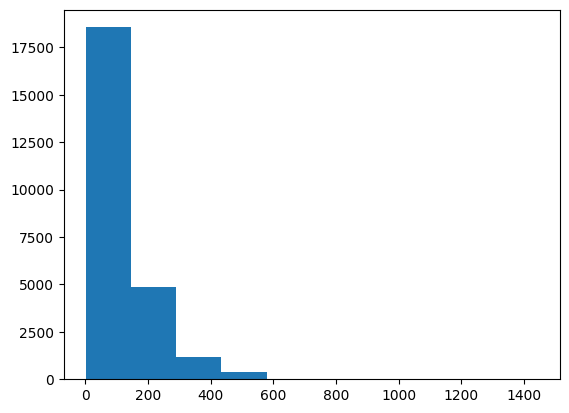

In [63]:
# length of reviews (histogram)
import matplotlib.pyplot as plt

plt.hist(sizes, bins=10, )

In [64]:
# ...

In [65]:
# print reviews and sentiment labels
for i in range(3):
    print(f"Review: {train['review'].iloc[i]} \n Sentiment: {train['sentiment'].iloc[i]}")

Review: Trio's vignettes were insightful and quite enjoyable. It was curious seeing so many soon to be famous actors when they were very young. The performances and attention to detail were wonderful to watch.<br /><br />Observation. In film it isn't necessary that source material be in alignment with the contemporary era to be interesting or worthwhile. "Small morality" storytelling is quaint (or coy) only in the eye of the beholder--thankfully. Story content--well told--can overcome it's time, subject or place.<br /><br />Ironically, there are quite a few contemporary films today that have not overcome the conventions or cutting edge mores of the present era. Inserting "small morality" content--occasionally--might provide a dimension lacking. 
 Sentiment: 1
Review: I had never heard of this one before the owner of my local DVD rental outlet mentioned it to me; being a 1980s horror flick with the notorious distinction of having been banned in the U.K., I decided to check it out. The f

## 3. Model Building

Now, we'll define our RNN architecture. A typical RNN consists of an embedding layer, RNN layers, and a fully connected layers.

### Exercise
1. Define a RNN class inheriting from torch.nn.Module.
2. Include one Embedding layer, two LSTM layers, and two Linear layers.

In [ ]:
import torch.nn as nn

class RecurrentModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RecurrentModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm1 = nn.LSTM(hidden_size, int(hidden_size/2), batch_first=True)
        self.lstm2 = nn.LSTM(int(hidden_size/2), int(int(hidden_size/2)/2), batch_first=True)
        self.fc1 = nn.Linear(int(int(hidden_size/2)/2), 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.activation(x)
        x, (h_n, c_n) = self.lstm2(x)
        x = self.fc1(h_n[-1])
        x = self.sigmoid(x)

        return x

## 4. Model Training

We'll now define the training loop to optimize our model using the binary cross-entropy loss function and the Adam optimizer.

### Exercise
1. Define a function to train the model for a specified number of epochs.
2. Print the training loss after each epoch.

In [67]:
from torch.nn import BCELoss
from torch.optim.adam import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RecurrentModel(input_size=len(vocab), hidden_size=300).to(device)

criteration = BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [68]:
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)  # Move to GPU
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(x)  # Forward pass
            loss = criterion(outputs.squeeze(), y.float())  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            
            running_loss += loss.item()  # Accumulate loss
            
            # Calculate accuracy
            predicted = (outputs.squeeze() > 0.5).long()  # Get predicted classes
            correct += (predicted == y).sum().item()  # Count correct predictions
            total += y.size(0)
        
        # Calculate average loss and accuracy
        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

train(model, train_loader, criteration, optimizer, epochs=5)

Epoch [1/5], Loss: 0.6935, Accuracy: 49.98%
Epoch [2/5], Loss: 0.6803, Accuracy: 53.19%
Epoch [3/5], Loss: 0.5367, Accuracy: 74.45%
Epoch [4/5], Loss: 0.3792, Accuracy: 84.48%
Epoch [5/5], Loss: 0.2960, Accuracy: 88.53%


## 5. Model Evaluation

After training, we need to evaluate our model on the test dataset to understand its performance.

### Exercise
1. Define a function to evaluate the model's accuracy on the test set.
2. Print the accuracy.

In [69]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            
            outputs = model(x)
            predicted = (outputs.squeeze() > 0.5).long()  # Get predicted classes
            correct += (predicted == y).sum().item()  # Count correct predictions
            total += y.size(0)
        
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

test(model, test_loader)

Test Accuracy: 83.32%
